In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

import joblib
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from indicator import Indicator
from trades_from_signal import pair_trade_backtest
from utils import price_dict_to_df
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
plt.style.use('dark_background')

In [ ]:
datas = joblib.load('/Users/leoinv/Documents/CODE/BACKTEST/data/1h.joblib') 
symbols = list(datas.keys())
datas = {symbol: df for symbol, df in datas.items() if symbol in symbols}
close = price_dict_to_df(datas)
close = close.ffill()

min_valid_rows = 20000
close = close.loc[:, close.notna().sum() >= min_valid_rows]
close = close.dropna()
rets = np.log(close).diff().dropna()

split_idx = int(len(rets.index) * 0.7)
train_to = rets.index[split_idx]
test_fr = train_to

corr_matrix_kendall = rets[: train_to].corr() #Just pearson

corr_pairs_kendall = (
    corr_matrix_kendall
    .where(np.triu(np.ones(corr_matrix_kendall.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs_kendall.columns = ["Asset1", "Asset2", "Corr"]

def rolling_zscore(series: pd.Series, window: int) -> pd.Series:
    """
    Computes a causal rolling Z-score to avoid look-ahead bias.
    """
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std(ddof=0)
    return (series - rolling_mean) / (rolling_std + 1e-9)

def indi_custom(ohlc: pd.DataFrame, lookback: int, atr_lookback: int = 10, z_window: int = 100):
    """
    Close minus moving average, normalized by ATR,
    combined with RSI of that series, both scaled using rolling Z-score.
    """
    atr = ta.atr(ohlc['high'], ohlc['low'], ohlc['close'], atr_lookback)
    ma = ohlc['close'].ewm(span=lookback, adjust=False).mean()

    value_np = (ohlc['close'] - ma) / atr

    ind = Indicator.relative_strength_index(value_np.values, lookback)
    ind = pd.Series(ind, index=ohlc.index)
    ind_ = value_np

    ind_norm = rolling_zscore(ind, z_window)
    ind__norm = rolling_zscore(ind_, z_window)
    
    vlu = 0.5 * ind_norm + 0.5 * ind__norm
    return vlu.rolling(window=atr_lookback).mean().fillna(0)

def get_pair_features(price_df, returns_df, pair):
    a1, a2 = pair

    # --- Check column existence ---
    if isinstance(price_df, pd.Series):
        price_df = pd.DataFrame({a1: price_df})
    if isinstance(returns_df, pd.Series):
        returns_df = pd.DataFrame({a1: returns_df})
        
    if a1 not in price_df.columns or a2 not in price_df.columns:
        raise KeyError(f"Missing price data for {a1} or {a2}")
    if a1 not in returns_df.columns or a2 not in returns_df.columns:
        raise KeyError(f"Missing returns data for {a1} or {a2}")

    # --- Ensure DatetimeIndex ---
    if not isinstance(price_df.index, pd.DatetimeIndex):
        try:
            price_df = price_df.copy()
            price_df.index = pd.to_datetime(price_df.index)
        except Exception as e:
            raise ValueError("Price DataFrame index must be datetime-like") from e

    if not isinstance(returns_df.index, pd.DatetimeIndex):
        try:
            returns_df = returns_df.copy()
            returns_df.index = pd.to_datetime(returns_df.index)
        except Exception as e:
            raise ValueError("Returns DataFrame index must be datetime-like") from e

    # --- Align prices ---
    p1 = price_df[a1].dropna()
    p2 = price_df[a2].dropna()
    price_idx = p1.index.intersection(p2.index)
    p1, p2 = p1.loc[price_idx], p2.loc[price_idx]
    
    # --- Align returns ---
    ret1 = returns_df[a1].dropna()
    ret2 = returns_df[a2].dropna()
    returns_idx = ret1.index.intersection(ret2.index)

    # Final common index
    final_idx = returns_idx.intersection(price_idx)
    ret1, ret2 = ret1.loc[final_idx], ret2.loc[final_idx]

    if ret1.empty or ret2.empty:
        return {f: np.nan for f in [
            'Corr_Pearson','Corr_Kendall','Covariance','Spread_Mean',
            'Volatility_Spread','Half_Life','Sharpe_Spread'
        ]}

    # Spread based on returns difference (log-returns spread)
    spread = ret1 - ret2
    spread_mean = spread.mean()

    corr_pearson = ret1.corr(ret2)
    corr_kendall = ret1.corr(ret2, method='kendall')
    cov = ret1.cov(ret2) * np.sqrt(252)

    spread_ret = ret1 - ret2
    vol_spread = spread_ret.std() * np.sqrt(252)

    spread_lag = spread.shift(1).dropna()
    spread_ret_aligned = spread.diff().dropna()
    spread_lag, spread_ret_aligned = spread_lag.align(spread_ret_aligned, join='inner')
    beta = np.polyfit(spread_lag, spread_ret_aligned, 1)[0] if not spread_lag.empty else np.nan
    half_life = -np.log(2) / beta if (beta is not None and beta < 0) else np.nan

    sharpe_spread = (spread_ret.mean() / spread_ret.std() * np.sqrt(252)
                     if spread_ret.std() > 0 else 0)

    return {
        'Corr_Pearson': corr_pearson,
        'Corr_Kendall': corr_kendall,
        'Covariance': cov,
        'Spread_Mean': spread_mean,
        'Volatility_Spread': vol_spread,
        'Half_Life': half_life,
        'Sharpe_Spread': sharpe_spread
    }

Data is ready


         Corr_Pearson  Corr_Kendall  Covariance  Spread_Mean  \
Cluster                                                        
0            0.620540      0.450665    0.000970    -0.000012   
1            0.648118      0.478582    0.000912     0.000067   
2            0.310578      0.222926    0.000236     0.000038   

         Volatility_Spread  Half_Life  Sharpe_Spread    Sharpe  
Cluster                                                         
0                 0.141617   0.674469      -0.023547 -0.030763  
1                 0.130202   0.683150       0.128891 -0.306211  
2                 0.147323   0.684526       0.066994  0.137430  


/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


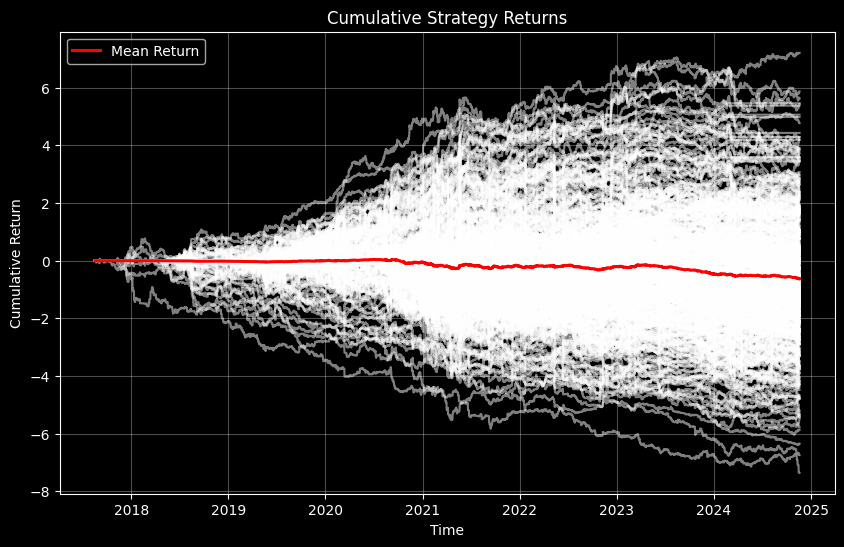

In [ ]:
top_pairs = corr_pairs_kendall[corr_pairs_kendall["Corr"] >= 0.0]

result = {}
for symbol1, symbol2 in zip(top_pairs['Asset1'], top_pairs['Asset2']):

    data1 = datas[symbol1]
    data2 = datas[symbol2]
    
    if 'open_time' in data1.columns:
        data1.set_index('open_time', inplace=True)
    if 'open_time' in data2.columns:
        data2.set_index('open_time', inplace=True)

    data1 = data1.loc[:train_to]
    data2 = data2.loc[:train_to]
    
    spread = np.log(data1['close']) - np.log(data2['close'])

    result[(symbol1, symbol2)] = {}
    indi_params = {
        'lookback': 30,
        'atr_lookback': 10,
    }

    res = pair_trade_backtest(data1, data2, indi_custom, 
                              plot=False, threshold=0.5, 
                              revert=True, fee_rate=0.0005,
                              **indi_params)

    result[(symbol1, symbol2)] = res['returns']
    
strat_rets = pd.DataFrame(result).fillna(0)
sharpe = strat_rets.mean() / strat_rets.std() * np.sqrt(365 * 24)

pairs = list(sharpe.keys())  
features_list = []
returns = np.log(close).diff().dropna()
for pair in pairs:
    feats = get_pair_features(close, returns, pair)
    feats['Asset1'], feats['Asset2'] = pair
    features_list.append(feats)

features_df = pd.DataFrame(features_list)
features_df.set_index(['Asset1', 'Asset2'], inplace=True)
features_df['Sharpe'] = sharpe

feature_cols = [col for col in features_df.columns if col not in ['Sharpe', 'Cluster']]

X = features_df[feature_cols].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features_df['Cluster'] = clusters

print(features_df.groupby('Cluster').mean())

# Plot cumulative returns
cum_strat_rets = strat_rets.cumsum()
plt.figure(figsize=(10, 6))

if isinstance(cum_strat_rets, pd.Series):
    plt.plot(cum_strat_rets, color='white', label='Strategy')
else:
    for col in cum_strat_rets.columns:
        plt.plot(cum_strat_rets.index, cum_strat_rets[col], color='white', alpha=0.5)
    plt.plot(cum_strat_rets.index, cum_strat_rets.mean(axis=1), 
             label="Mean Return", linewidth=2.2, color='red')

plt.title("Cumulative Strategy Returns", color='white')
plt.xlabel("Time", color='white')
plt.ylabel("Cumulative Return", color='white')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

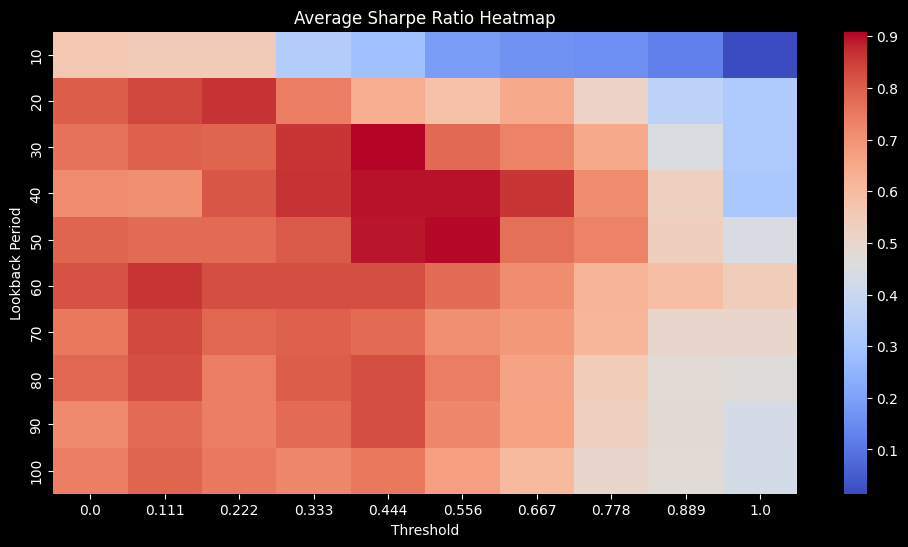

In [ ]:
import seaborn as sns

top_symbols = sharpe.groupby(level=0).mean().sort_values(ascending=False)[:5].index.tolist()
test_pairs = features_df.sort_values(by='Sharpe', ascending=False)[:50].index
test_pairs = test_pairs.to_frame(index=False).reset_index(drop=True)
test_pairs = test_pairs[
    test_pairs['Asset1'].isin(top_symbols) | test_pairs['Asset2'].isin(top_symbols)
].reset_index(drop=True)

heatmaps = []
for asset1, asset2 in zip(test_pairs['Asset1'], test_pairs['Asset2']):
    data1 = datas[asset1][:train_to]
    data2 = datas[asset2][:train_to]
    
    sh_df = pd.DataFrame()

    for lb in np.linspace(10, 100, 10):
        for th in np.linspace(0.00, 1, 10):
            indi_params = {
                'lookback': int(lb),
                'atr_lookback': 10
            }
            res = pair_trade_backtest(data1, data2, indi_custom, 
                                    plot=False, threshold=th, 
                                    revert=True, fee_rate=0.001,
                                    **indi_params)

            rets = res['returns']
            sh_df.loc[lb, round(th, 3)] = rets.mean() / rets.std() * np.sqrt(365 * 24)

    heatmaps.append(sh_df)

# Average as before
all_heatmaps = pd.concat(heatmaps, keys=range(len(heatmaps)))
avg_heatmap = all_heatmaps.groupby(level=1).mean()

plt.figure(figsize=(12, 6))
sns.heatmap(avg_heatmap, annot=False, fmt='0.3g', cmap='coolwarm')
plt.xlabel('Threshold')
plt.ylabel('Lookback Period')
plt.title('Average Sharpe Ratio Heatmap')
plt.show()

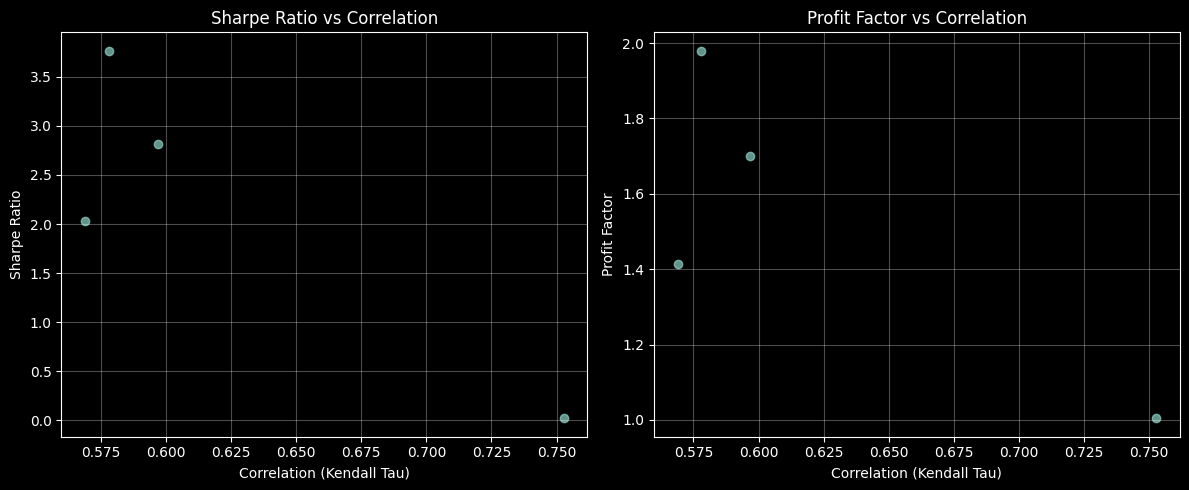

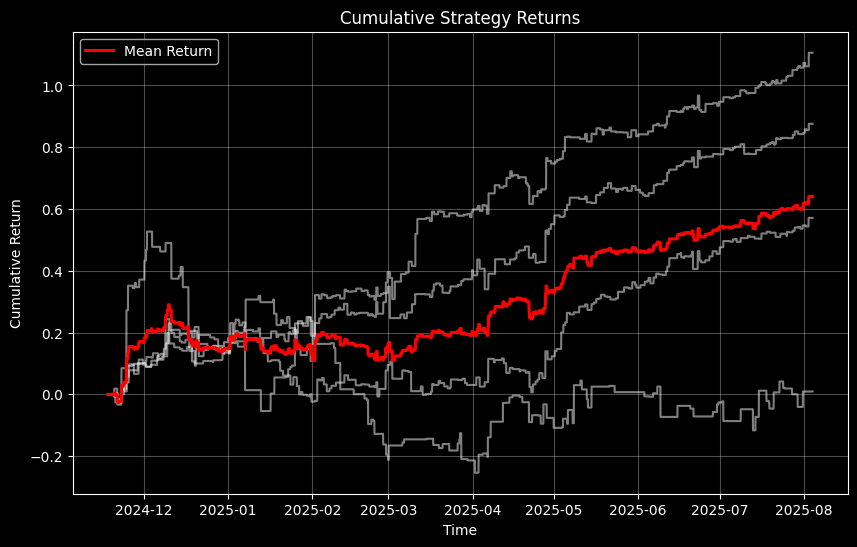

               CAR  Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
NEXOUSDT  1.852474    0.301892      3.472622     -0.105065     17.631691
STXUSDT   0.013378    0.617426      0.021527     -0.511250      0.026167
AVG       0.932926    0.459659      1.747075     -0.308157      8.828929


In [ ]:
top_symbols = sharpe.groupby(level=0).mean().sort_values(ascending=False)[:5].index.tolist()
test_pairs = features_df.sort_values(by='Sharpe', ascending=False)[:20].index
test_pairs = test_pairs.to_frame(index=False).reset_index(drop=True)
test_pairs = test_pairs[
    test_pairs['Asset1'].isin(top_symbols) | test_pairs['Asset2'].isin(top_symbols)
].reset_index(drop=True)

result = {}
for symbol1, symbol2 in zip(test_pairs['Asset1'], test_pairs['Asset2']):

    data1 = datas[symbol1]
    data2 = datas[symbol2]
    
    if 'XMRUSDT' in [symbol1, symbol2]:
        continue

    if 'open_time' in data1.columns:
        data1.set_index('open_time', inplace=True)
    if 'open_time' in data2.columns:
        data2.set_index('open_time', inplace=True)

    data1 = data1.loc[test_fr:]
    data2 = data2.loc[test_fr:]
    
    data1_ = data1.loc[:train_to]
    data2_ = data2.loc[:train_to]

    rets = np.log(data1_['close']).diff() - np.log(data2_['close']).diff() 

    result[(symbol1, symbol2)] = {}
    
    indi_params = {
        'lookback': 40,
        'atr_lookback': 10,
    }
    
    res = pair_trade_backtest(data1, data2, indi_custom, 
                            plot=False, threshold=0.5, 
                            revert=True, fee_rate=0.0005,
                            **indi_params)


    result[(symbol1, symbol2)] = res['returns']
    
    
strat_rets = pd.DataFrame(result).fillna(0)

sharpe = strat_rets.mean() / strat_rets.std() * np.sqrt(365 * 24)
gross_profit = strat_rets[strat_rets > 0].sum()
gross_loss = abs(strat_rets[strat_rets < 0].sum())
profit_factor = gross_profit / gross_loss

sharpe_df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in sharpe.to_dict().items()],
    columns=['Asset1', 'Asset2', 'Sharpe']
)
pf_df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in profit_factor.to_dict().items()],
    columns=['Asset1', 'Asset2', 'ProfitFactor']
)

# Compute Kendall tau correlation matrix
corr_matrix_kendall = close.pct_change()[test_fr:].corr() 

# Extract upper triangle pairs
corr_pairs_kendall = (
    corr_matrix_kendall
    .where(np.triu(np.ones(corr_matrix_kendall.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs_kendall.columns = ["Asset1", "Asset2", "Corr"]


corr_pairs_kendall = corr_pairs_kendall.rename(columns={"Kendall_Tau": "Corr"})
merged = (
    pd.merge(corr_pairs_kendall, sharpe_df, on=['Asset1', 'Asset2'], how='inner')
    .merge(pf_df, on=['Asset1', 'Asset2'], how='inner')
)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(merged['Corr'], merged['Sharpe'], alpha=0.7)
plt.xlabel('Correlation (Kendall Tau)')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Correlation')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(merged['Corr'], merged['ProfitFactor'], alpha=0.7)
plt.xlabel('Correlation (Kendall Tau)')
plt.ylabel('Profit Factor')
plt.title('Profit Factor vs Correlation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Plot cumulative returns
cum_strat_rets = strat_rets.cumsum()
plt.figure(figsize=(10, 6))

if isinstance(cum_strat_rets, pd.Series):
    plt.plot(cum_strat_rets, color='white', label='Strategy')
else:
    for col in cum_strat_rets.columns:
        plt.plot(cum_strat_rets.index, cum_strat_rets[col], color='white', alpha=0.5)
    plt.plot(cum_strat_rets.index, cum_strat_rets.mean(axis=1), 
             label="Mean Return", linewidth=2.2, color='red')

plt.title("Cumulative Strategy Returns", color='white')
plt.xlabel("Time", color='white')
plt.ylabel("Cumulative Return", color='white')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


from utils import performance_metrics

results = {}
for pair in cum_strat_rets.columns:
    symbol = pair[1]
    results[symbol] = performance_metrics(cum_strat_rets[pair]*1000 + 1000, periods_per_year=365*24)
    
result_df = pd.DataFrame(results)
result_df['AVG'] = result_df.mean(axis=1)
print(result_df.T)